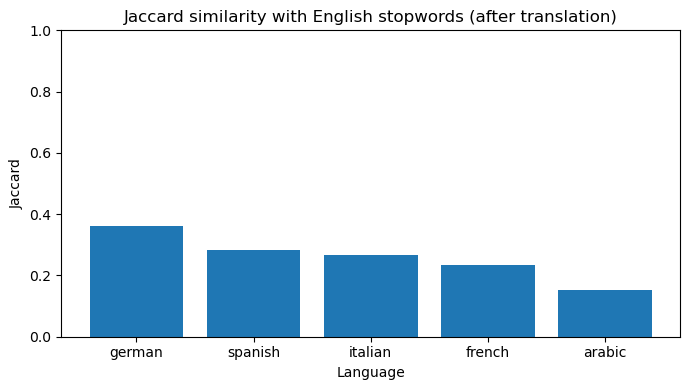


Saved files (relative):
- artifacts/spec4_translation_jaccard_summary.csv
- artifacts/spec4_jaccard_bar.png
- artifacts/spec4_ar_translated_stopwords.csv
- artifacts/spec4_fr_translated_stopwords.csv
- artifacts/spec4_es_translated_stopwords.csv
- artifacts/spec4_de_translated_stopwords.csv
- artifacts/spec4_it_translated_stopwords.csv
- artifacts/spec4_translation_cache.json  # translation cache


In [1]:
# Spec 4: Translate non-English stopwords -> English, compare with English stopwords (Jaccard)
# - Uses deep-translator (GoogleTranslator) with simple caching
# - Saves per-language translation tables + Jaccard summary + bar plot to artifacts/

import os, re, json, time
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# ---------- paths (work from root or notebooks/) ----------
ART_DIR  = os.path.abspath("../artifacts" if os.path.basename(os.getcwd())=="notebooks" else "./artifacts")
os.makedirs(ART_DIR, exist_ok=True)

# ---------- deps ----------
for pkg in ["stopwords"]:
    nltk.download(pkg, quiet=True)
from nltk.corpus import stopwords

# install deep-translator if missing
try:
    from deep_translator import GoogleTranslator
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "deep-translator"])
    from deep_translator import GoogleTranslator

# ---------- config ----------
LANGS = [
    ("arabic",  "ar"),
    ("french",  "fr"),
    ("spanish", "es"),
    ("german",  "de"),
    ("italian", "it"),
]
EN_LIST = set(stopwords.words("english"))

CACHE_PATH = os.path.join(ART_DIR, "spec4_translation_cache.json")

# ---------- tiny cache helpers ----------
def load_cache(path):
    if os.path.exists(path):
        try:
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception:
            return {}
    return {}

def save_cache(path, obj):
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(obj, f, ensure_ascii=False, indent=2)
    except Exception:
        pass

cache = load_cache(CACHE_PATH)  # key = f"{src}:{word}" -> translated (str)

# ---------- text cleaning ----------
_alpha = re.compile(r"^[a-zA-Z]+$")
def normalize_en_token(tok: str) -> str:
    """Lowercase and keep alphabetic tokens only."""
    t = tok.strip().lower()
    return t if _alpha.match(t) else ""

def translate_words(words, src_lang, delay=0.0):
    """
    Translate a list of words from src_lang -> English.
    Uses cache and translate_batch for speed; falls back to per-item on errors.
    """
    tr = GoogleTranslator(source=src_lang, target="en")
    out = []
    batch = []
    # prepare batch with caching
    to_translate = []
    for w in words:
        key = f"{src_lang}:{w}"
        if key in cache:
            out.append((w, cache[key]))
        else:
            to_translate.append(w)

    # batch translate remaining
    # deep-translator translate_batch accepts a list of strings
    CHUNK = 50
    for i in range(0, len(to_translate), CHUNK):
        chunk = to_translate[i:i+CHUNK]
        try:
            res = tr.translate_batch(chunk)
        except Exception:
            # fallback: try one-by-one for this chunk
            res = []
            for w in chunk:
                try:
                    res.append(tr.translate(w))
                    if delay: time.sleep(delay)
                except Exception:
                    res.append("")  # mark as empty on failure
        # store cache + collect
        for w, r in zip(chunk, res):
            # sometimes translation returns multi-word; keep first word that is alphabetic
            cand = ""
            for piece in str(r).split():
                norm = normalize_en_token(piece)
                if norm:
                    cand = norm
                    break
            cache[f"{src_lang}:{w}"] = cand
            out.append((w, cand))
        if delay:
            time.sleep(delay)

    # attach cached ones we had already
    # (they were appended before batch section)
    return out

# ---------- main ----------
summary_rows = []
per_lang_csv = []

for nltk_name, src_code in LANGS:
    try:
        L_src = sorted(set(stopwords.words(nltk_name)))
    except OSError:
        print(f"[SKIP] NLTK stopwords not available for {nltk_name}.")
        continue

    # translate list to English
    pairs = translate_words(L_src, src_code, delay=0.0)
    df_tr = pd.DataFrame(pairs, columns=["original", "translated"])

    # clean: drop empties, keep unique translated tokens
    df_tr["translated"] = df_tr["translated"].astype(str).str.strip().str.lower()
    df_tr = df_tr[df_tr["translated"] != ""].drop_duplicates(subset=["translated"]).reset_index(drop=True)

    # compute Jaccard against NLTK English stopwords
    tr_set = set(df_tr["translated"].tolist())
    inter  = tr_set & EN_LIST
    union  = tr_set | EN_LIST
    jacc   = (len(inter) / len(union)) if union else 0.0

    # save per-language translation table
    out_csv = os.path.join(ART_DIR, f"spec4_{src_code}_translated_stopwords.csv")
    df_tr.to_csv(out_csv, index=False)
    per_lang_csv.append(os.path.basename(out_csv))

    summary_rows.append({
        "language": nltk_name,
        "code": src_code,
        "src_stopwords": len(L_src),
        "translated_unique": len(tr_set),
        "english_reference": len(EN_LIST),
        "overlap": len(inter),
        "union": len(union),
        "jaccard": round(jacc, 4),
        "csv_translated": os.path.basename(out_csv)
    })

# save cache back
save_cache(CACHE_PATH, cache)

# ---------- summary table ----------
df_sum = pd.DataFrame(summary_rows).sort_values("jaccard", ascending=False)
sum_csv = os.path.join(ART_DIR, "spec4_translation_jaccard_summary.csv")
df_sum.to_csv(sum_csv, index=False)

# ---------- bar plot ----------
plt.figure(figsize=(7,4))
plt.bar(df_sum["language"], df_sum["jaccard"])
plt.ylim(0,1)
plt.title("Jaccard similarity with English stopwords (after translation)")
plt.ylabel("Jaccard")
plt.xlabel("Language")
plt.tight_layout()
bar_png = os.path.join(ART_DIR, "spec4_jaccard_bar.png")
plt.savefig(bar_png, dpi=150)
plt.show()

# ---------- prints (relative paths) ----------
print("\nSaved files (relative):")
print(f"- artifacts/{os.path.basename(sum_csv)}")
print(f"- artifacts/{os.path.basename(bar_png)}")
for fn in per_lang_csv:
    print(f"- artifacts/{fn}")
print(f"- artifacts/{os.path.basename(CACHE_PATH)}  # translation cache")
